In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tensorflow import lite as tflite

from BirdNET import config as cfg
from BirdNET import analyze
#from BirdNET import audio
from BirdNET import model
from BirdNET import embeddings

from classifier import utilities

In [ ]:
#Backup
class_map = {
        'catharus_ustulatus_Call_1'     : 0,
        'catharus_ustulatus_Call_2'     : 1,
        'catharus_ustulatus_Song_1'     : 2, 
        'empidonax_difficilis_Call_1'   : 3, 
        'empidonax_difficilis_Call_2'   : 4,
        'empidonax_difficilis_Song_1'   : 5,
        'loxia_curvirostra_Call_1'      : 6, 
        'loxia_curvirostra_Song_1'      : 7,
        'poecile_rufescens_Call_1'      : 8, 
        'poecile_rufescens_Call_2'      : 9,
        'poecile_rufescens_Call_3'      : 10,
        'poecile_rufescens_Call_4'      : 11,
        'setophaga_occidentalis_Call_1' : 12, 
        'setophaga_occidentalis_Song_1' : 13,
        'troglodytes_pacificus_Call_1'  : 14, 
        'troglodytes_pacificus_Call_2'  : 15,
        'troglodytes_pacificus_Call_3'  : 16,
        'troglodytes_pacificus_Song_1'  : 17, 
}


In [2]:
classifier_model = classifier.load_model('classifier/checkpoints/v_0.h5')
def generate_class_map(FG_FOLDER):
    import os
    dirnames = os.listdir(FG_FOLDER)
    dirnames.sort() 
    class_map = {}
    for i, dirname in enumerate(dirnames):
        class_map[dirname] = i
    return class_map

class_map = classifier.generate_class_map("data/foreground/")


In [3]:

print(class_map)


{'catharus_ustulatus_Call_1': 0, 'catharus_ustulatus_Call_2': 1, 'catharus_ustulatus_Song_1': 2, 'empidonax_difficilis_Call_1': 3, 'empidonax_difficilis_Call_2': 4, 'empidonax_difficilis_Song_1': 5, 'loxia_curvirostra_Call_1': 6, 'loxia_curvirostra_Song_1': 7, 'poecile_rufescens_Call_1': 8, 'poecile_rufescens_Call_2': 9, 'poecile_rufescens_Call_3': 10, 'poecile_rufescens_Call_4': 11, 'setophaga_occidentalis_Call_1': 12, 'setophaga_occidentalis_Song_1': 13, 'troglodytes_pacificus_Call_1': 14, 'troglodytes_pacificus_Call_2': 15, 'troglodytes_pacificus_Call_3': 16, 'troglodytes_pacificus_Song_1': 17}


In [3]:
#utility functions
def process_wav(wav):
    chunks = analyze.getRawAudioFromFile(wav)
    samples = []
    for c in range(len(chunks)):
        samples.append(chunks[c])
    data = np.array(samples, dtype='float32')
    e = model.embeddings(data) 
    scores = classifier_model(e)
    scores = scores.numpy()
    return scores

def display_results(wav, scores, class_map, write_fig):    
    import numpy as np
    import matplotlib.pyplot as plt
    import librosa
    import librosa.display

    y, sr = librosa.load(wav)
    file_length = len(y)/sr
    fig, ax = plt.subplots(nrows=3, ncols=1, constrained_layout=True)
    fig.suptitle(wav, fontsize=16)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr = sr, x_axis='time')
    plt.xlim([0, file_length])
    plt.subplot(3, 1, 2)
    D = np.abs(librosa.core.stft(y))
    D = librosa.amplitude_to_db(D,ref=np.max)
    librosa.display.specshow(D, y_axis='linear', x_axis='time', sr = sr)
    plt.ylim([0, 12000])
    plt.xlim([0, file_length])
    plt.subplot(3, 1, 3)
    top_N = len(class_map.keys())
    top_class_indices = range(0, top_N , 1)
    #y_tick_labels = [get_keys_from_value(class_map, x) for x in yticks]
    xvals = [0,len(y)/sr]
    yvals = [1,5]
    #plt.imshow(scores[:, top_class_indices].T,extent=[xvals[0],xvals[1],yvals[0],yvals[1]], aspect='auto',  cmap='gray_r')
    plt.imshow(scores[:, top_class_indices].T, aspect='auto',  cmap='gray_r', vmin=0, vmax=1)
    patch_padding = (3 / 2) / 3
    #plt.xlim([0, scores.shape[0] + patch_padding])
    plt.xlim([-0.5, scores.shape[0] - 0.5])
    def get_keys_from_value(d, val):
        return [k for k, v in d.items() if v == val]
    yticks = range(0, top_N, 1)
    plt.yticks(yticks, [get_keys_from_value(class_map, x) for x in yticks]);
    out_name = wav.split('\\')[-1].split('.')[0]
    if(write_fig): plt.savefig(f"figures\\{out_name}.png")
    plt.close(fig)
    return fig

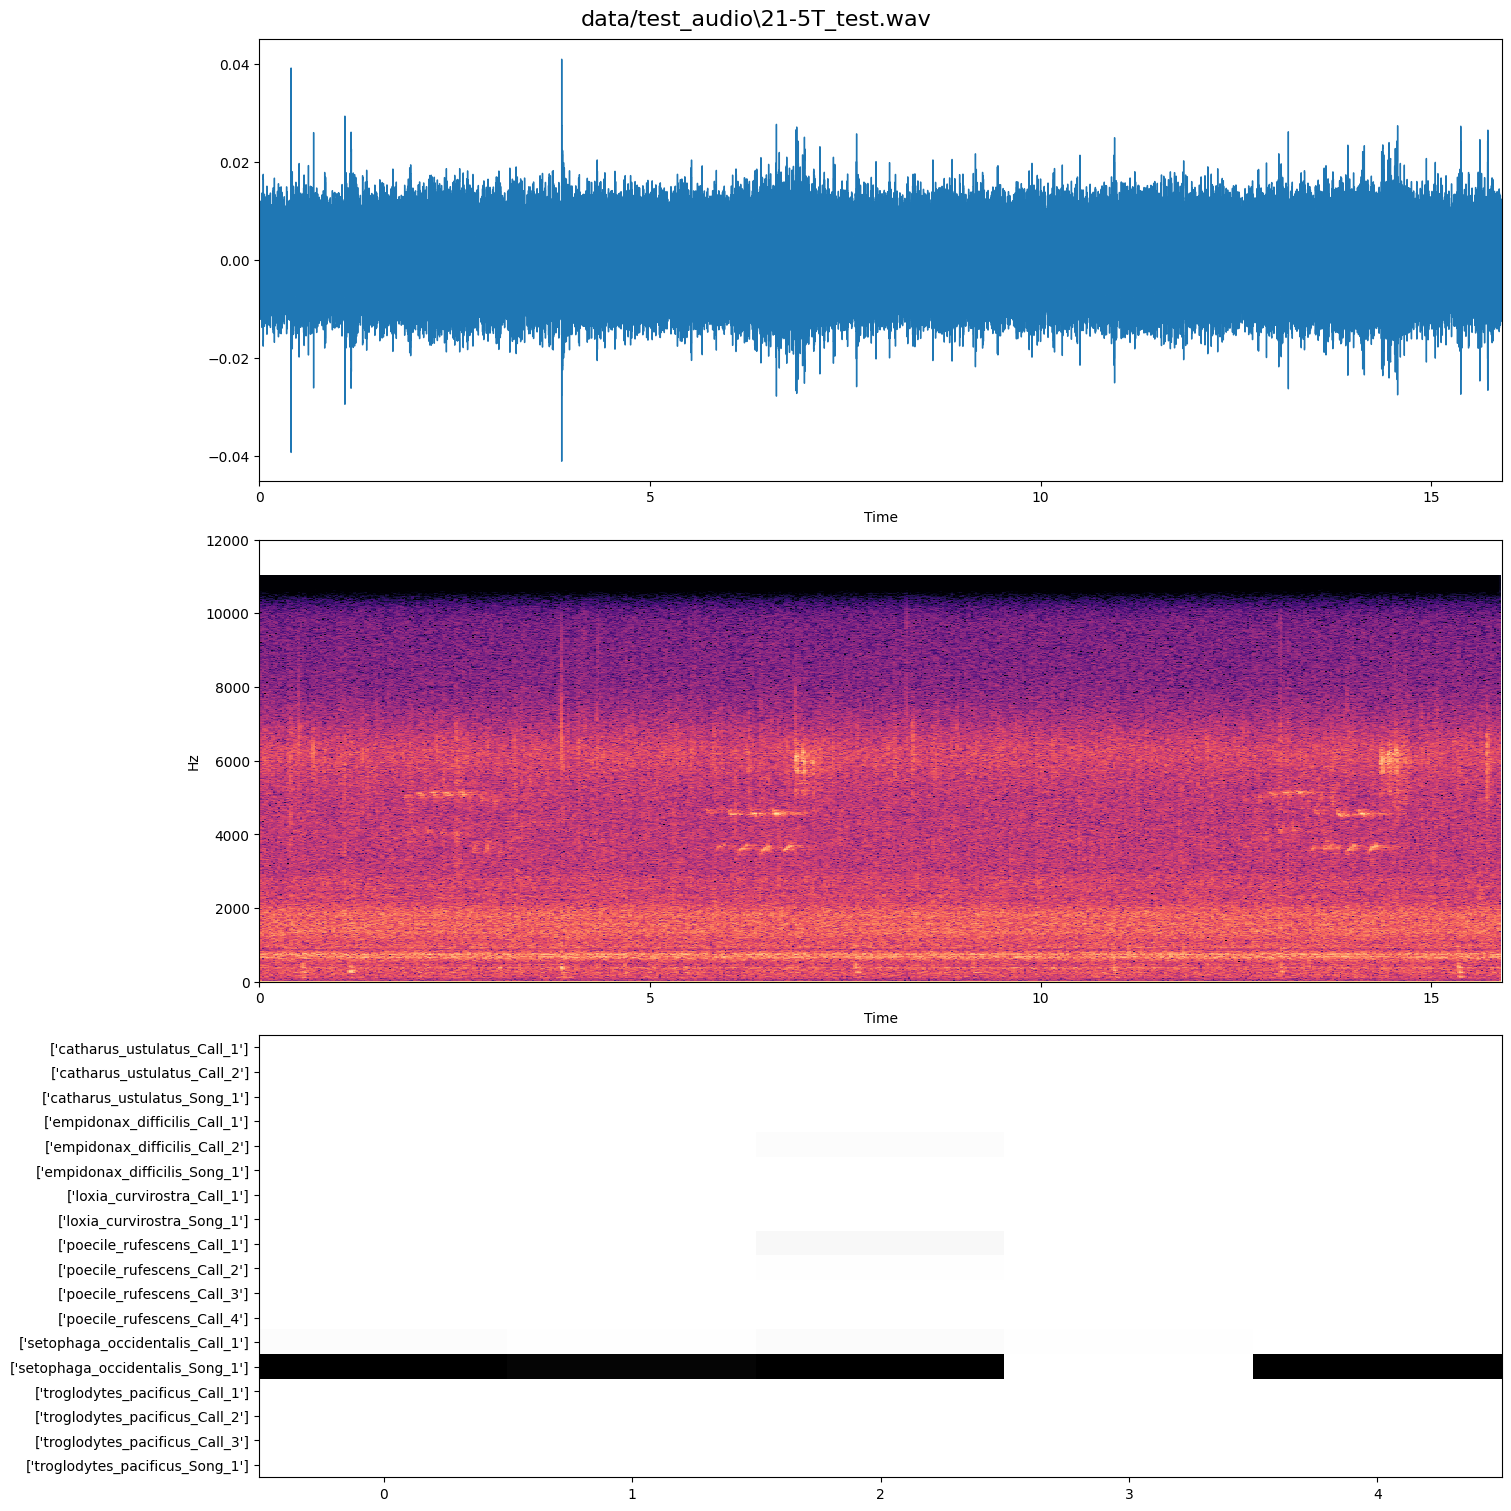

In [5]:
wavs = glob.glob('data/test_audio/*.wav')
wav = wavs[0]
scores = process_wav(wav)
display_results(wav, scores, class_map, True) #third argument controls whether or not to write the image to the figures directory

In [44]:
df = pd.DataFrame(scores, columns=class_map.keys())
out_name = wav.split('\\')[-1].split('.')[0]
df.to_csv(f'data/clean/{out_name}.csv')